# Keras neural network Image Classification with Vanishing and Exploding Gradients
* notebook by Adam Lang
* Date: 2/23/2024
* We will demonstrate `Vanishing Gradients` and `Exploding Gradients` to reduce overfitting in a neural network.


# Problem Statement
* Classify images of vehicles as emergency or non-emergency (i.e. firetruck, police car vs. regular car)
* Binary classification problem.
      1 = emergency
      2 = non-emergency

# What are Vanishing/Exploding Gradients?
* Usually a problem with DEEPER neural networks with more hidden layers.
* This occurs during the backpropagation step where the weights and biases are updated with the gradient descent algorithm.
* This is the backpropogation algorithm where we update the weights and biases:
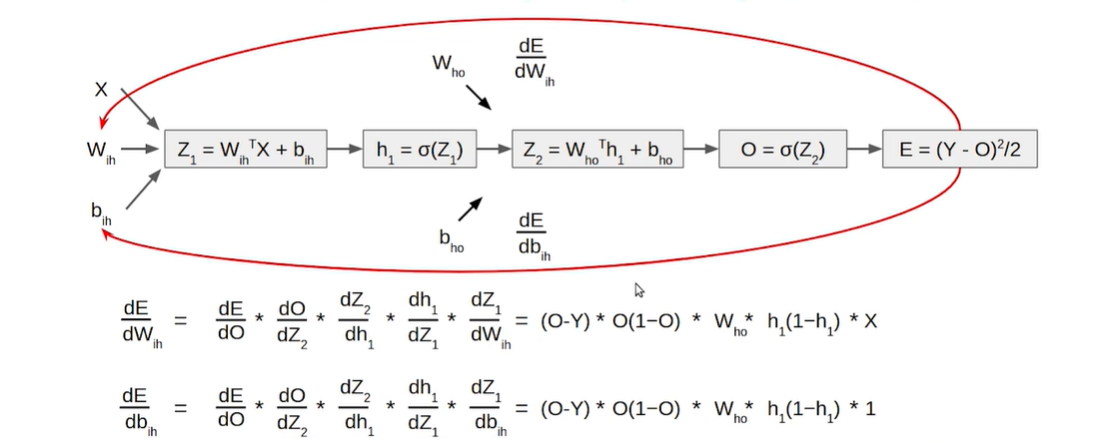


# Example of Vanishing Gradient
* Consider the update of weights and biases between input layer and 1st hidden layer.
* If value of gradient descent update is very small, the updated weights will end up closer to zero as seen here:
* Thus the result is the initial weights are NOT updated with backpropagation as seen below in the green box. Thus our outcome of this layer will not change.

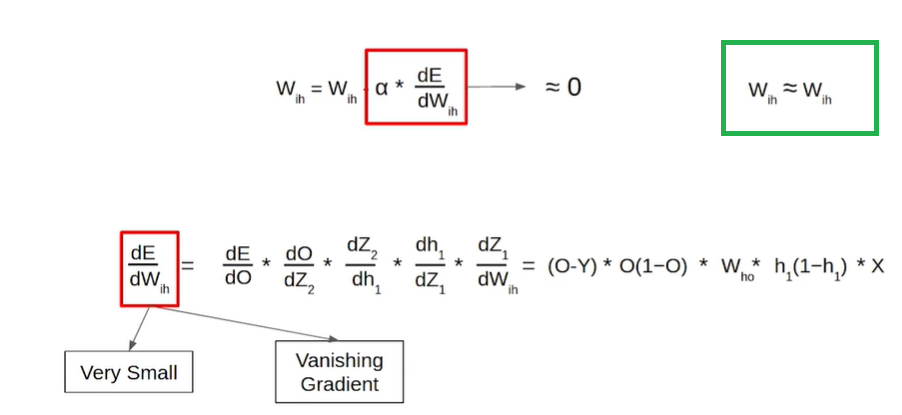

# Example of Exploding Gradient
* Now let's again consider the update of weights and biases between input layer and 1st hidden layer.
* If value of gradient descent update is very LARGE, the updated weights will end up with LARGE updates in weights and biases.
* Thus the result is the initial weights are continually updated with larger values and the model never converts or optimizes the gradient descent algorithm.
* We can see below here the equation for gradient descent where: `alpha * dE/dWih` product is very large and this creates the `exploding gradient`.

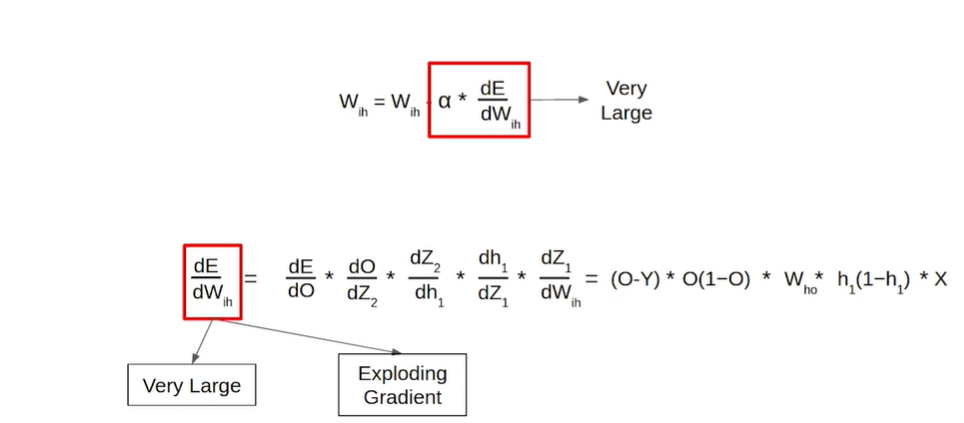

# Numeric example of Vanishing vs. Exploding gradient problem
* The 1st row of floats shows a `Vanishing Gradient`. We can see the value does not change. Thus, the initial weights and biases are not updated during back propagation.
* The 2nd row of floats shows an `Exploding Gradient`. We can see the gradient fluxates significantly up and down. Normally this can explode as much as 100's to 1,000's or more thus the gradient descent never optimize and updates the weights and biases.
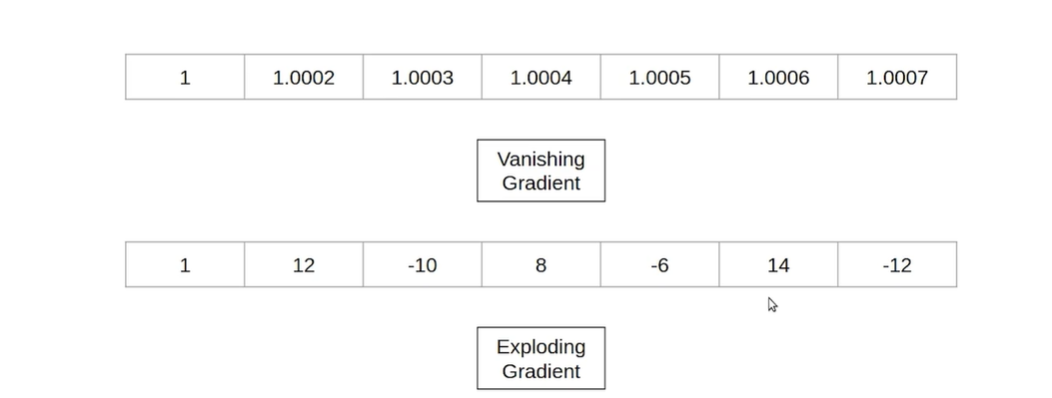

# How can a value of a gradient become "Vanishing"?
* Red values below are derivatives of values in the activation functions.
* Blue values below are changes of Z1 and Z2 with respect to hidden layer activations.

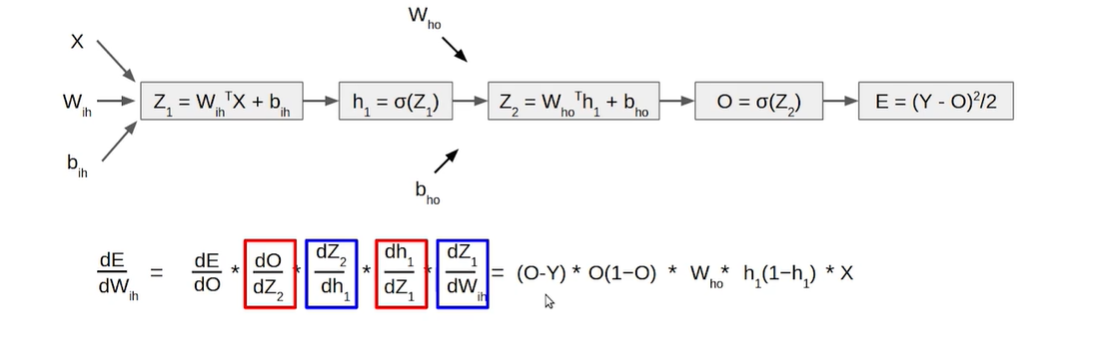

# Vanishing Gradient problem breakdown
* Let's start with the activation function derivatives (red boxes).
* Let's assume we are using the `sigmoid` activation function which outputs 0 or 1.
* The sigmoid activation function below reveals that the maximum value of the derivative of our sigmoid activation function is 0.25 (red box).

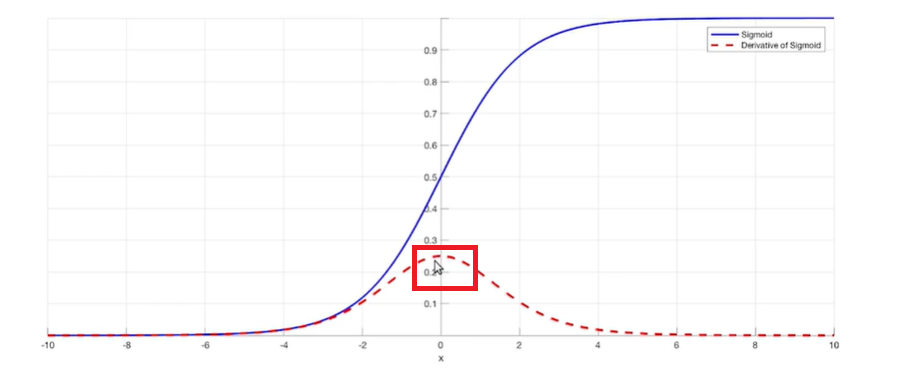

* Let's say we were using a `tanh` activation function.
* In a vanishing gradient problem the derivative would be closer to 1.
* A normal `tanh` activation function is between -1 and 1.
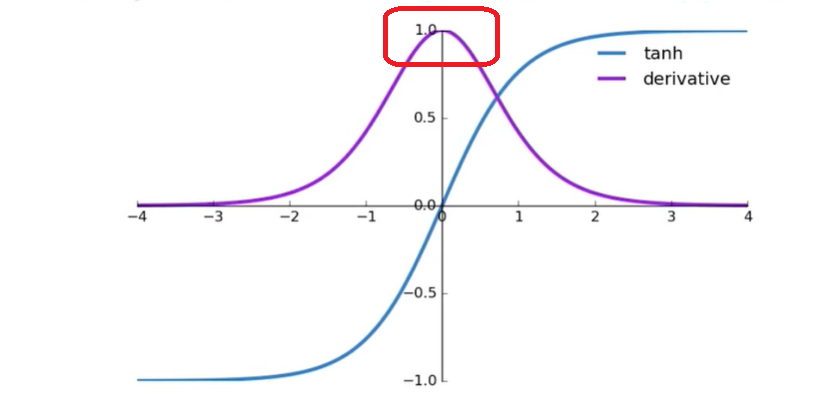


# Math behind Vanishing Gradient
* We can see if the values of the activation functions are 0.2 and they are squared we get 0.04 which is much smaller.
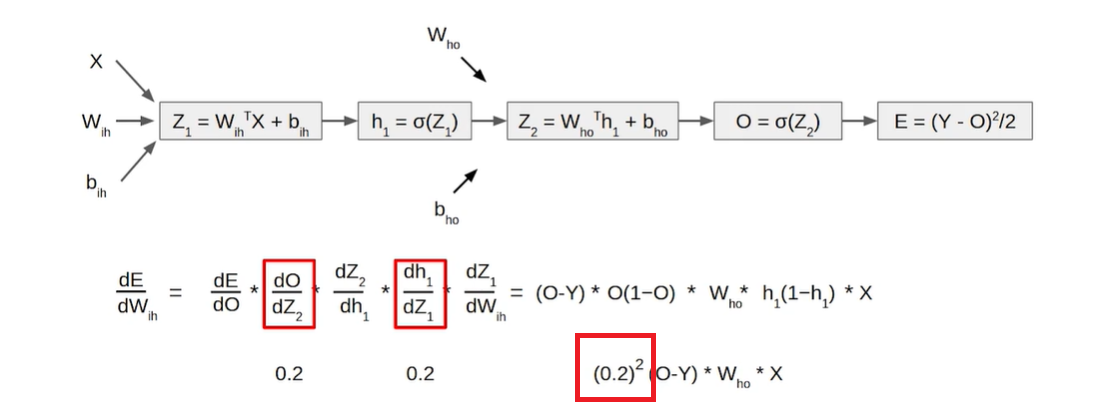

* So, if we add more layers (deeper network) this becomes significantly smaller, thus it is vanishing!
* If we added 10 layers this would result in 0.2^10 which is 1.024e-7 which is very very small.
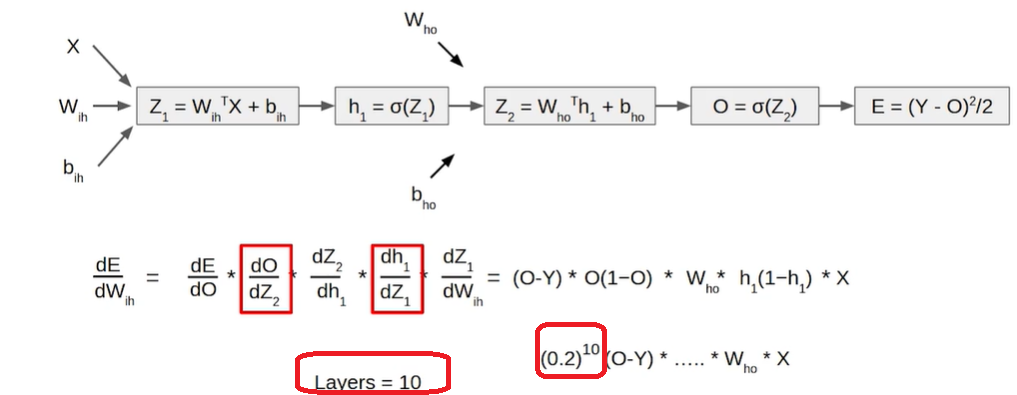


# Solution to Vanishing Gradient is to use Relu activation function
* Relu derivative is always 1 for positive values and thus prevents the gradient from vanishing.
* Relu has a derivative of 0 to infinity.
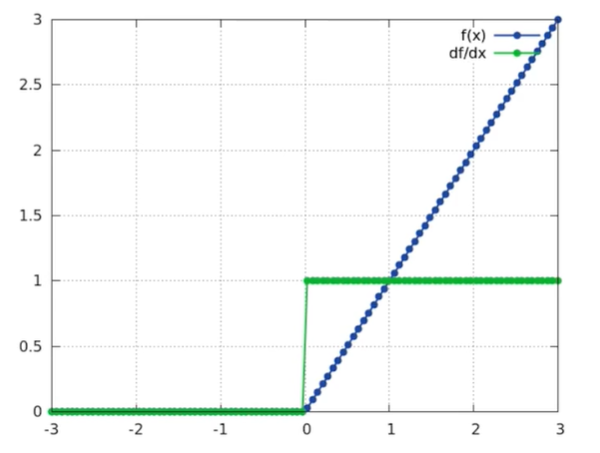

# Weight initialization can also cause Vanishing Gradient problem
* See Keras docs: https://keras.io/api/layers/initializers/
* Equation with weights in blue boxes:

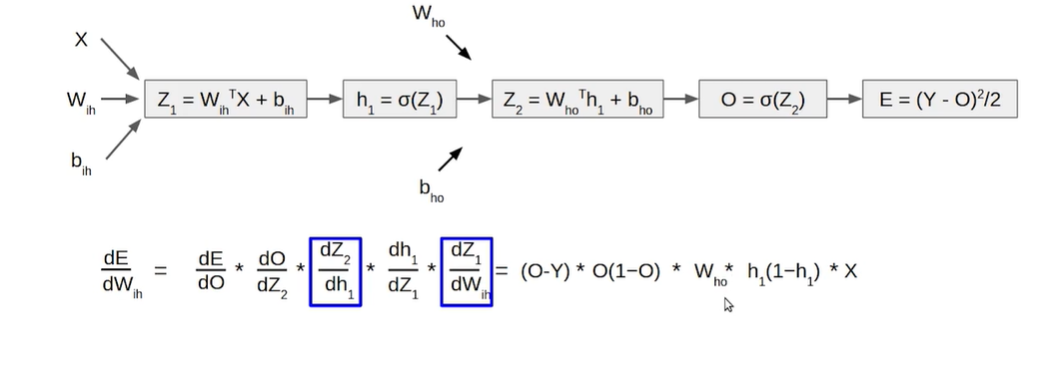



# How does an Exploding Gradient occur?
* Similar issue as with vanishing gradient just with larger values.
* In mathematical equation below we can see a situation where you may have chosen an activation function where the derivative is > 1 or in this case 1.5.
* So the outcome would be 1.5^2 = 2.25
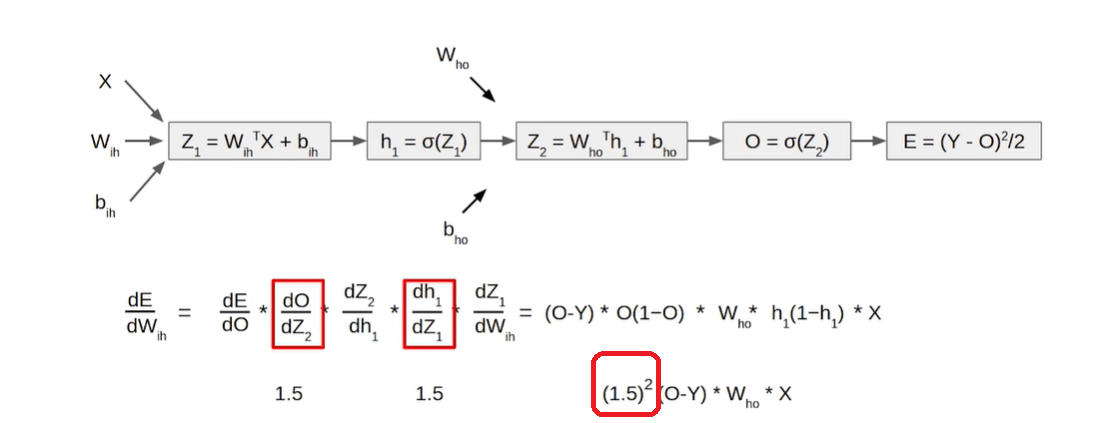

* But what happens if instead of 2 layers you have 10 layers?
* Mathematically speaking you get 1.5^10 = 57.6 which is then multiplied by the remaining weights and biases and you can now see how this gradient rapidly explodes.
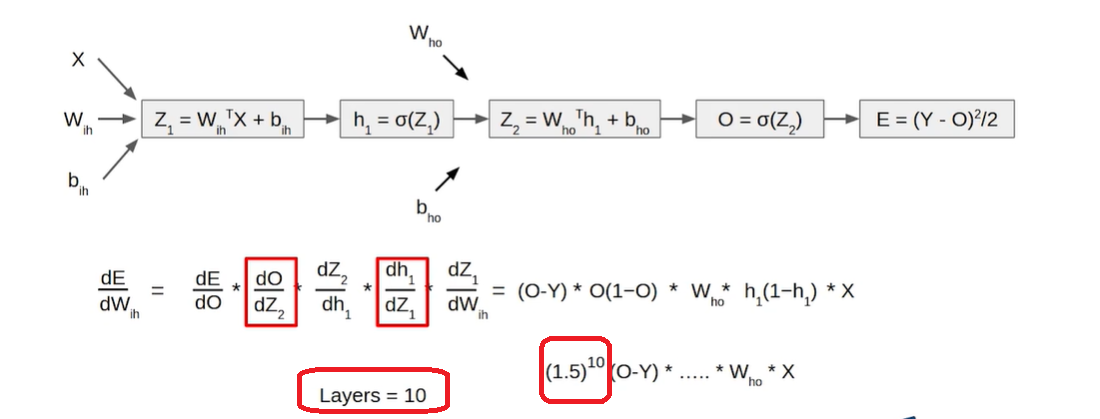

# How do weights cause Exploding gradients?
* Initalizing the neural network weights between hidden and output layer.
* If these values are too high => result is an Exploding gradient!

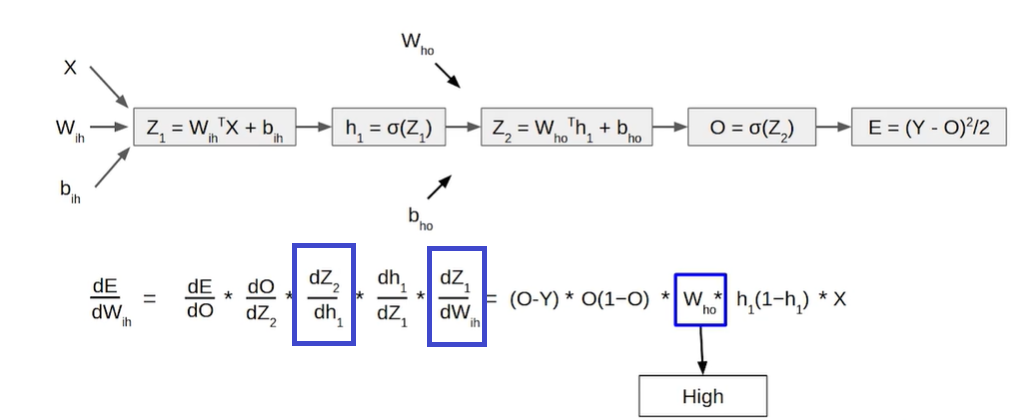

# Solution(s) to Exploding Gradient
* There are many solutions, but 1 is `Gradient Clipping`.
    * clips derivatives or gradients.
    * defines a threshold: `clipvalue`

* If we define a clipvalue of 1, we have to normalize to this value.

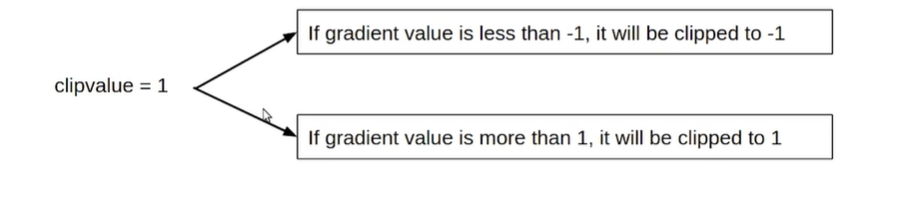

# Steps to solve image classification problem using Gradient Clipping
1. Load dataset
2. Pre-process data
3. Create training and validation sets
4. Define model architecture
5. **Compiling the model - define clipvalue while defining optimizer**
6. Train model
7. Evaluate model performance

# Demonstration of Gradient Clipping in Keras

1. Loading dataset

In [6]:
# import libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import layers from keras
from keras.layers import Dense, InputLayer
from keras.models import Sequential
# importing adam optimizer form keras optimizer module
from keras.optimizers import Adam

# train_test_split to create training and validaiton sets
from sklearn.model_selection import train_test_split
# accuracy_score to calculate accuracy of predictions
from sklearn.metrics import accuracy_score

In [7]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### use git commands to get to file

In [8]:
ls

drive/  sample_data/


In [15]:
cd Deep\ Learning\ Notebooks

/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks


In [16]:
# unzip contents
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/emergency_classification.csv  
   creating: Dataset/images/
  inflating: Dataset/images/0.jpg    
  inflating: Dataset/images/10.jpg   
  inflating: Dataset/images/1002.jpg  
  inflating: Dataset/images/1006.jpg  
  inflating: Dataset/images/1007.jpg  
  inflating: Dataset/images/1009.jpg  
  inflating: Dataset/images/1013.jpg  
  inflating: Dataset/images/1014.jpg  
  inflating: Dataset/images/1016.jpg  
  inflating: Dataset/images/1019.jpg  
  inflating: Dataset/images/102.jpg  
  inflating: Dataset/images/1020.jpg  
  inflating: Dataset/images/1022.jpg  
  inflating: Dataset/images/1023.jpg  
  inflating: Dataset/images/1026.jpg  
  inflating: Dataset/images/1031.jpg  
  inflating: Dataset/images/1035.jpg  
  inflating: Dataset/images/1036.jpg  
  inflating: Dataset/images/1037.jpg  
  inflating: Dataset/images/104.jpg  
  inflating: Dataset/images/1040.jpg  
  inflating: Dataset/images/1041.jpg  
  inflating: Dataset/

In [17]:
# read in csv files
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/Dataset/emergency_classification.csv')

In [18]:
# create random number seed generator so we can replicate data
seed = 42
rng = np.random.RandomState(seed)

In [19]:
# load images and store in numpy array

# empty list to store images
X = []
# iterate over every image
for img_name in data.image_names:
  # loading image using its name
  img = plt.imread('Dataset/images/' + img_name)
  # saving each image in list
  X.append(img)


# converting list of images into array
X=np.array(X)

# storing target variable in separate variable
y = data.emergency_or_not.values

# 2. Pre-processing the data

In [20]:
# converting 3 dim image to 1 dim image
X = X.reshape(X.shape[0], 224*224*3)
X.shape

(2352, 150528)

In [21]:
# normalizing pixel values between 0 and 1
X = X / X.max()

# min and max pixel values of images after normalizing
X.min(), X.max()

(0.0, 1.0)

# 3. Creating training and validation sets

In [22]:
# creating training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=seed)

In [23]:
# shape of training and validation sets
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1646, 150528), (1646,)), ((706, 150528), (706,)))

# 4. Define model architecture

In [24]:
# defining model architecture with dropout layer
model = Sequential()

model.add(InputLayer(input_shape=(224*224*3,))) #input layer
model.add(Dense(100, activation='sigmoid')) #hidden layer 1
model.add(Dense(100, activation='sigmoid')) #hidden layer 2
model.add(Dense(units=1, activation='sigmoid')) #output layer with 1 neuron for binary classification

# 5. Compiling the model
* Add the `clipvalue`
* `clip value` will clip gradient values during backpropagation

In [25]:
# defining the adam optimizer and setting the learning rate as 10^-5 and adding clip value to clip the gradients
adam = Adam(learning_rate=1e-5, clipvalue=1)

In [26]:
# compile model

# define loss as binary crossentropy
# define optimizer as Adam
# define metrics as accuracy

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# 6. Training the model

In [27]:
# train model for 100 epochs
model_history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid))

Epoch 1/30
13/13 [==============================] - 10s 658ms/step - loss: 0.6783 - accuracy: 0.5893 - val_loss: 0.6574 - val_accuracy: 0.6091
Epoch 2/30
13/13 [==============================] - 9s 731ms/step - loss: 0.6431 - accuracy: 0.6349 - val_loss: 0.6326 - val_accuracy: 0.6742
Epoch 3/30
13/13 [==============================] - 7s 540ms/step - loss: 0.6326 - accuracy: 0.6476 - val_loss: 0.6209 - val_accuracy: 0.6813
Epoch 4/30
13/13 [==============================] - 9s 731ms/step - loss: 0.6184 - accuracy: 0.6713 - val_loss: 0.6123 - val_accuracy: 0.6799
Epoch 5/30
13/13 [==============================] - 8s 590ms/step - loss: 0.6069 - accuracy: 0.6859 - val_loss: 0.6083 - val_accuracy: 0.6771
Epoch 6/30
13/13 [==============================] - 9s 678ms/step - loss: 0.5976 - accuracy: 0.7053 - val_loss: 0.6003 - val_accuracy: 0.6870
Epoch 7/30
13/13 [==============================] - 9s 687ms/step - loss: 0.5911 - accuracy: 0.7108 - val_loss: 0.5960 - val_accuracy: 0.6898
Epoch

# 7. Evaluate the model's performance on validation set

In [28]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, model.predict(X_valid).argmax(axis=1)), '%')

23/23 [==============================] - 1s 54ms/step
Accuracy on validation set: 0.5609065155807366 %


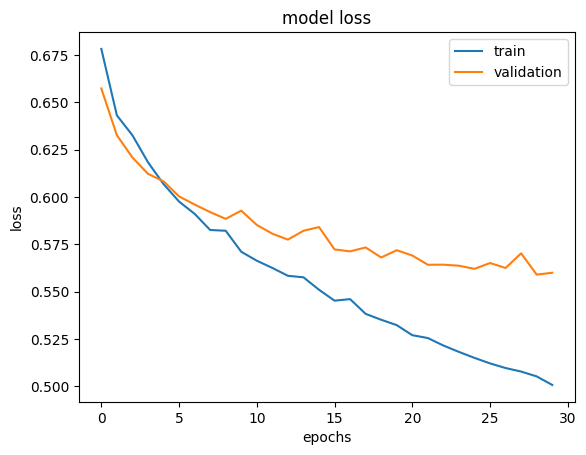

In [29]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Summary:
* We used gradient clipping to prevent exploding gradients.
* We can see the accuracy on the validation set was not great, it was ~56%.
* Based on the plot above, we can see the model performed well on the validation set up until ~epoch 8, then it appears the model loss leveled out and did not continue to decrease and it significantly overfit the data.
* Based on the very little change seen in the val_loss, we could assume that we have a vanishing gradient problem.
* Below we will attempt to solve this by implementing a `relu` activation function instead of `sigmoid` for hidden layers.

# Experiment to fix outcome with relu

### Define model architecture
* use relu instead of sigmoid for hidden layers

In [ ]:
# defining model architecture with dropout layer
model = Sequential()

model.add(InputLayer(input_shape=(224*224*3,))) #input layer
model.add(Dense(100, activation='relu')) #hidden layer 1
model.add(Dense(100, activation='relu')) #hidden layer 2
model.add(Dense(units=1, activation='sigmoid')) #output layer with 1 neuron for binary classification

### define optimizer and compile model

In [31]:
# define learning rate a 10^-5
adam = Adam(learning_rate=1e-5)

In [32]:
# compile model

# define loss as binary crossentropy
# define optimizer as Adam
# define metrics as accuracy

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

### Train model again

In [ ]:
# train model for 100 epochs
model_history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid))

### Evaluate performance

In [ ]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, model.predict(X_valid).argmax(axis=1)), '%')

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()